In [95]:
import numpy as np
import matplotlib.pyplot as plt
import math
from scipy.stats import poisson

In [186]:
def q_simple_count(mu, n_obs, sig, bkg, debug=False):
    """
    Compute test statistic q for a single-bin experiment
    mu: the assumed signal strength
    n_obs: number of observed events
    sig: expected number of signal events
    bkg: expected number of bkg events
    """
    mu_opt = (n_obs-bkg)/sig # Would normally be a fit but easy in this case
    L_opt = poisson_likelihood(n_obs, mu_opt, sig, bkg)
    L_this_mu = poisson_likelihood(n_obs, mu, sig, bkg)
    _lambda = L_this_mu / L_opt
    q = -2*np.log(_lambda)
    if debug:
        if isinstance(mu, np.ndarray):
            print(f'{L_opt=}')
            print(f'{L_this_mu=}')
            print(f'{mu=}')
            print(f'{q=}')
            for _mu in mu: q_simple_count(_mu, n_obs, sig, bkg, debug)
        else:
            print(f'{mu=:.2f}, {mu_opt=:.2f}, {L_opt=:.5f}, {L_this_mu=:.5f}, lambda={_lambda:.5f}, {q=:.5f}')
    return q

def q_asimov(mu, mu_true, sig, bkg):
    n_true = mu_true * sig + bkg
    L_asimov = poisson_likelihood(n_true, mu_true, sig, bkg)
    L_this_mu = poisson_likelihood(n_true, mu, sig, bkg)
    _lambda = L_this_mu / L_asimov
    q = -2*np.log(_lambda)
    return q

def sigma_squared_asimov(mu, mu_true, sig, bkg):
    return mu**2 / q_asimov(mu, mu_true, sig, bkg)

def manual_poisson_likelihood(n_obs, mu, sig, bkg):
    n_exp = mu*sig+bkg
    return n_exp**n_obs / math.factorial(n_obs) * np.exp(-n_exp)

def poisson_likelihood(n_obs, mu, sig, bkg):
    return poisson.pmf(n_obs, mu*sig+bkg)

def solve_polynomial(polynomial_fit, y_value):
    the_fit = polynomial_fit.copy()
    the_fit[-1] -= y_value
    return np.roots(the_fit)


For low statistics, the chi2 (parabolic) assumption of q doesn't hold:

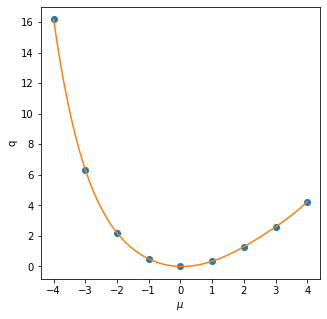

In [187]:
fig = plt.Figure(facecolor='white', figsize=(5,5))
ax = fig.gca()
mu = np.linspace(-4, 4, 9, dtype=np.int64)

q = q_simple_count(mu, n_obs=10, sig=2, bkg=10)
ax.plot(mu, q, 'o')

# Also plot a fit
mu_for_fit = np.linspace(min(mu), max(mu), 100)
y_fit = np.polyval(np.polyfit(mu, q, 6), mu_for_fit)
ax.plot(mu_for_fit, y_fit)
ax.set_xlabel(r'$\mu$')
ax.set_ylabel(r'q')
fig

For high statistics q(mu) is parabolic:

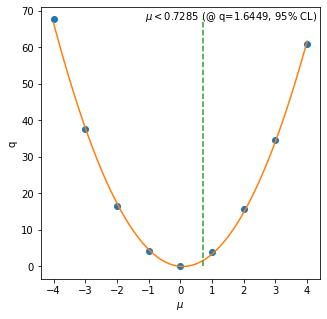

In [189]:
fig = plt.Figure(facecolor='white', figsize=(5,5))
ax = fig.gca()
mu = np.linspace(-4, 4, 9, dtype=np.int64)

n_obs = 10000
sig = 200
bkg = 10000

q = q_simple_count(mu, n_obs, sig, bkg)
ax.plot(mu, q, 'o')

# Also plot a fit
mu_for_fit = np.linspace(min(mu), max(mu), 100)
quadratic_fit = np.polyfit(mu, q, 2)
q_fit = np.polyval(quadratic_fit, mu_for_fit)
ax.plot(mu_for_fit, q_fit)

# Solve for q = 1.6449; throw away the negative root
q_cl95 = 1.6449
sigma_squared = sigma_squared_asimov(1., 0., sig, bkg)
mu_cl95 = max(solve_polynomial(quadratic_fit, q_cl95))

ax.plot([mu_cl95, mu_cl95], [0., max(q)], '--')
ax.text(
    0.99, .99, f'$\\mu < {mu_cl95:.4f}$ (@ q={q_cl95}, 95% CL)',
    horizontalalignment='right',
    verticalalignment='top',
    transform=ax.transAxes
    )
ax.set_xlabel(r'$\mu$')
ax.set_ylabel(r'q')
fig

In [183]:
q_asimov(1., 0., sig, bkg)

3.9474540764349513

In [184]:
sigma_squared_asimov(1., 0., sig, bkg)

0.2533278362805239

Based on second derivates (https://arxiv.org/pdf/1007.1727.pdf , Eq.27)

In [185]:
sigma = bkg / sig**2
sigma

0.25